$\textbf{Contributors}$ :\
Wouter Kessels @TU Delft (wouter@wouterkessels.nl)\
Byoung-moo Ann @TU Delft (byoungmoo.Ann@gmail.com)

# Simulation overview.

## Main goal : Calculate sideband transition rates between a qubit and cavity.

The main goal of this notebook is to calculate the two-photon first order sideband transition rates between a qubit and cavity induced by external transverse driving fields. The transition schemes are depicted below.

<table width="400">
    <tr>
        <td>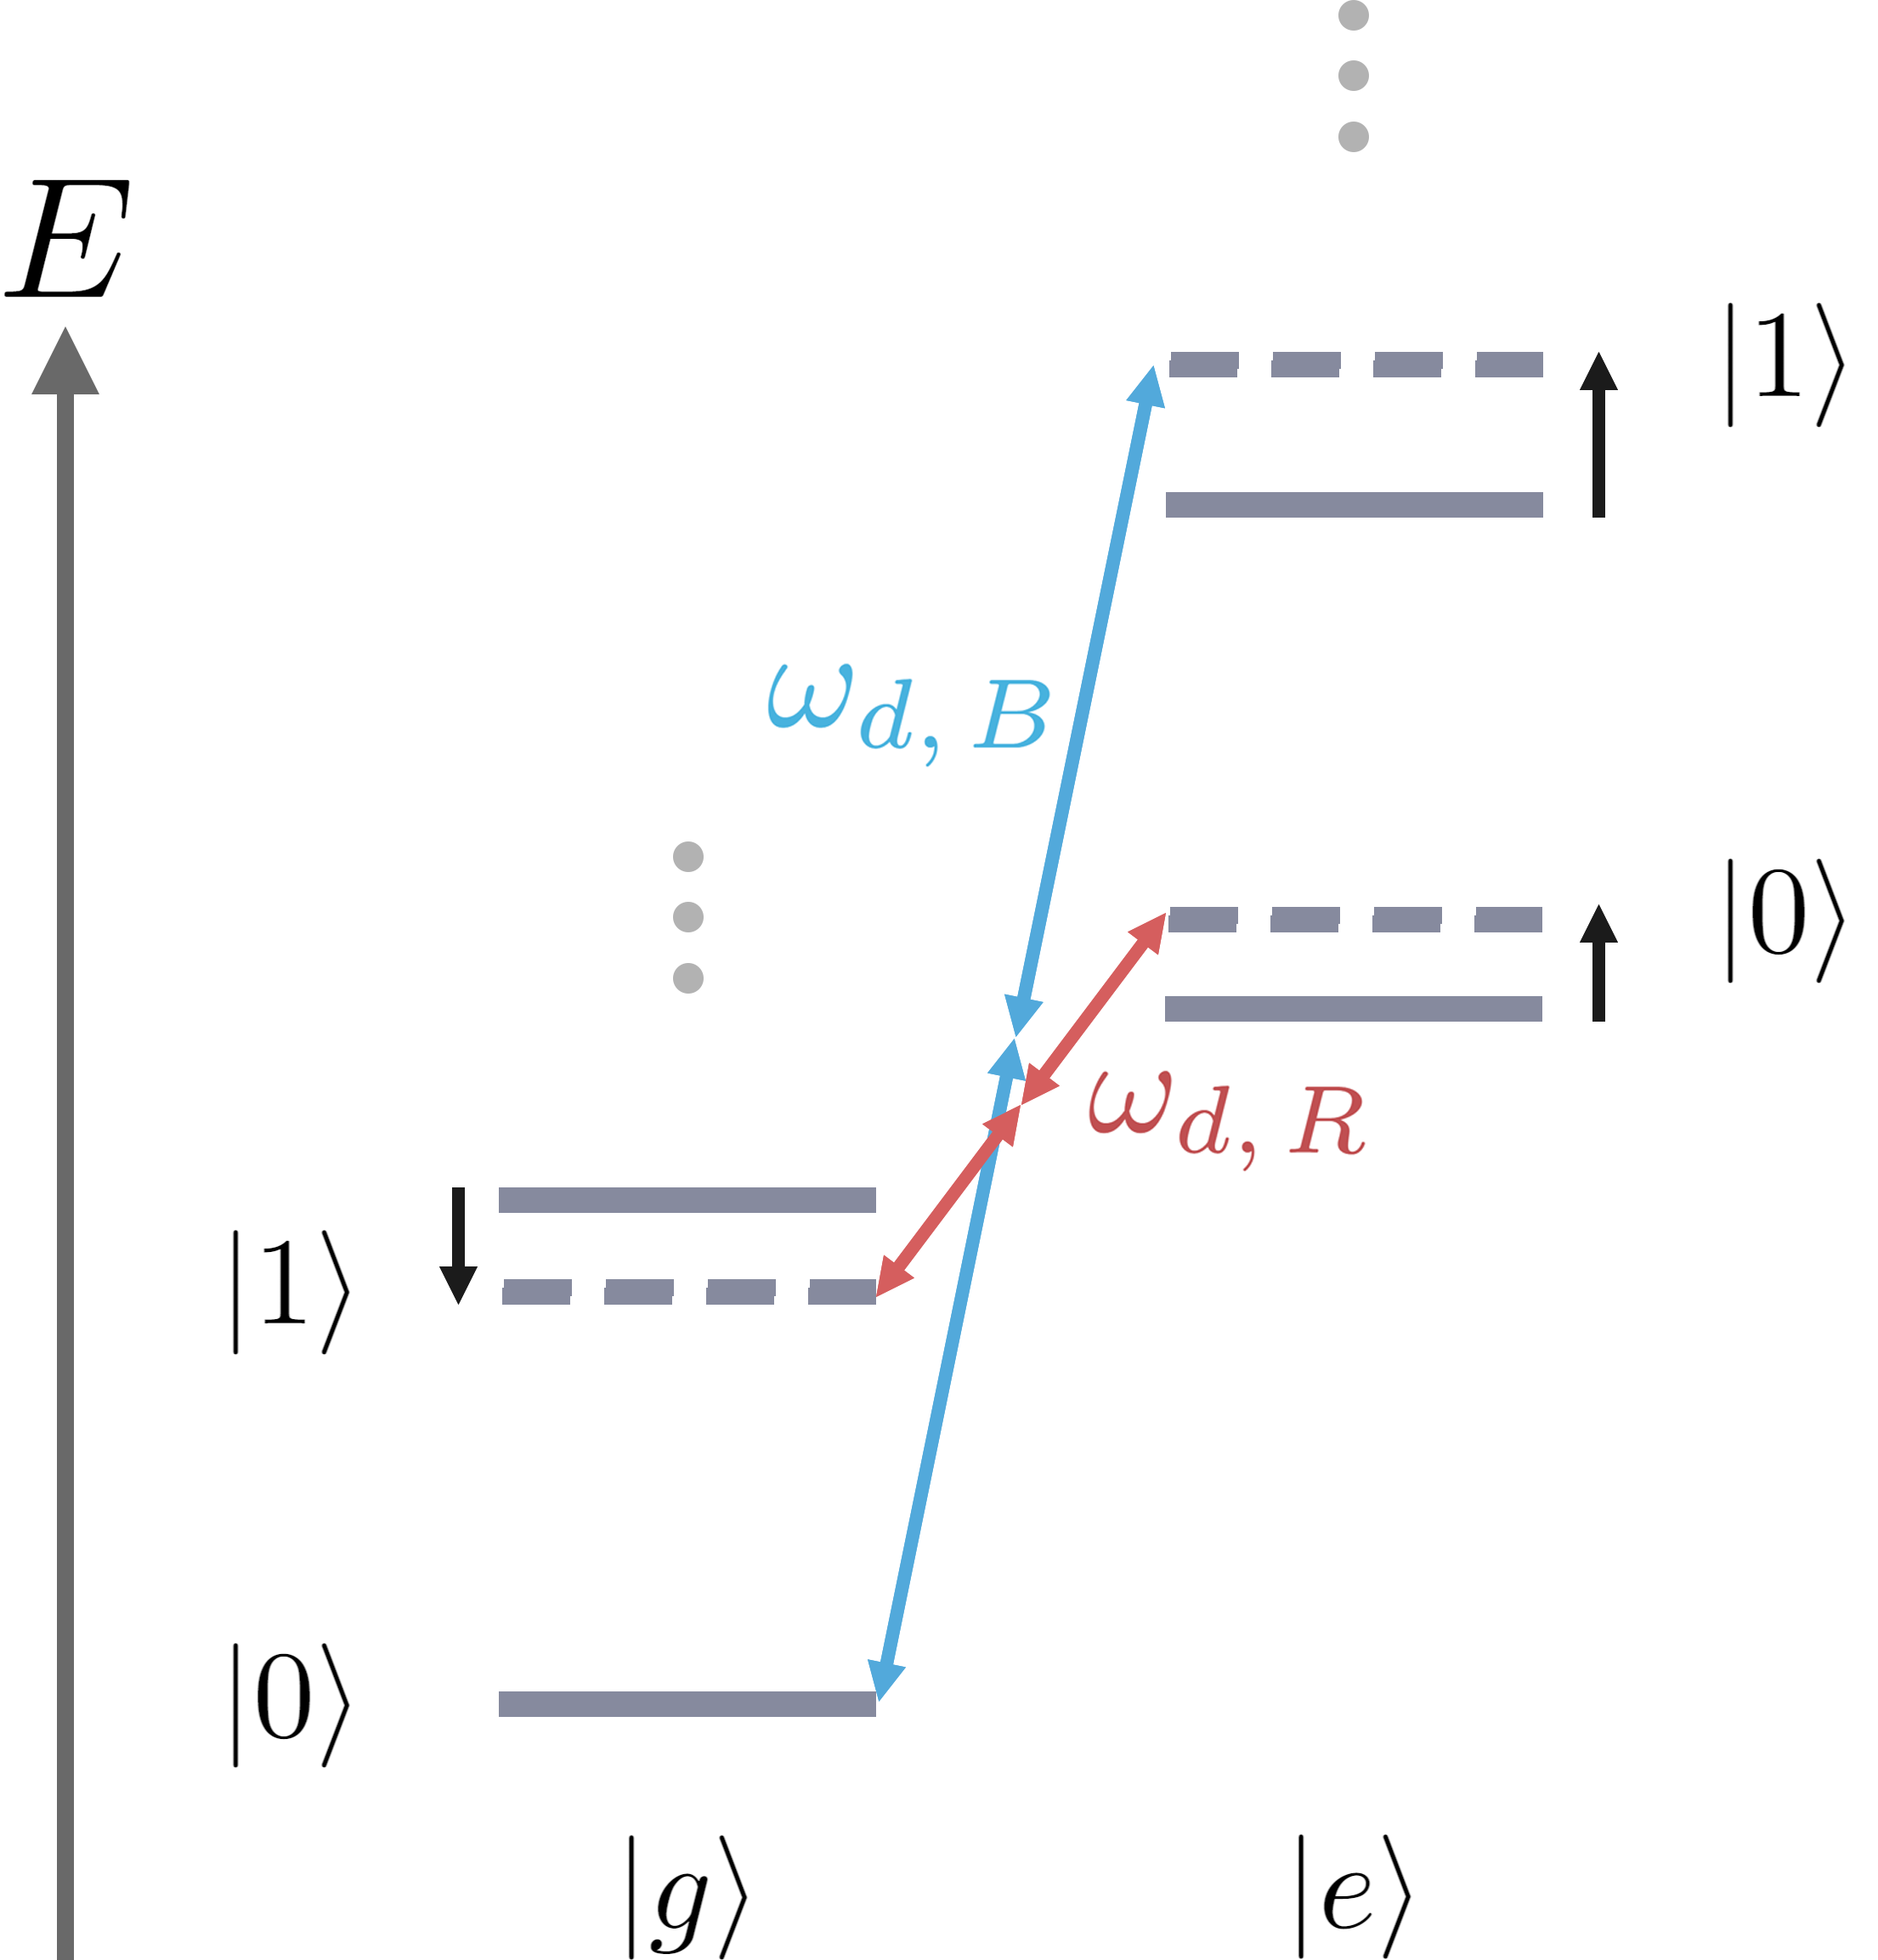</td>
        <td>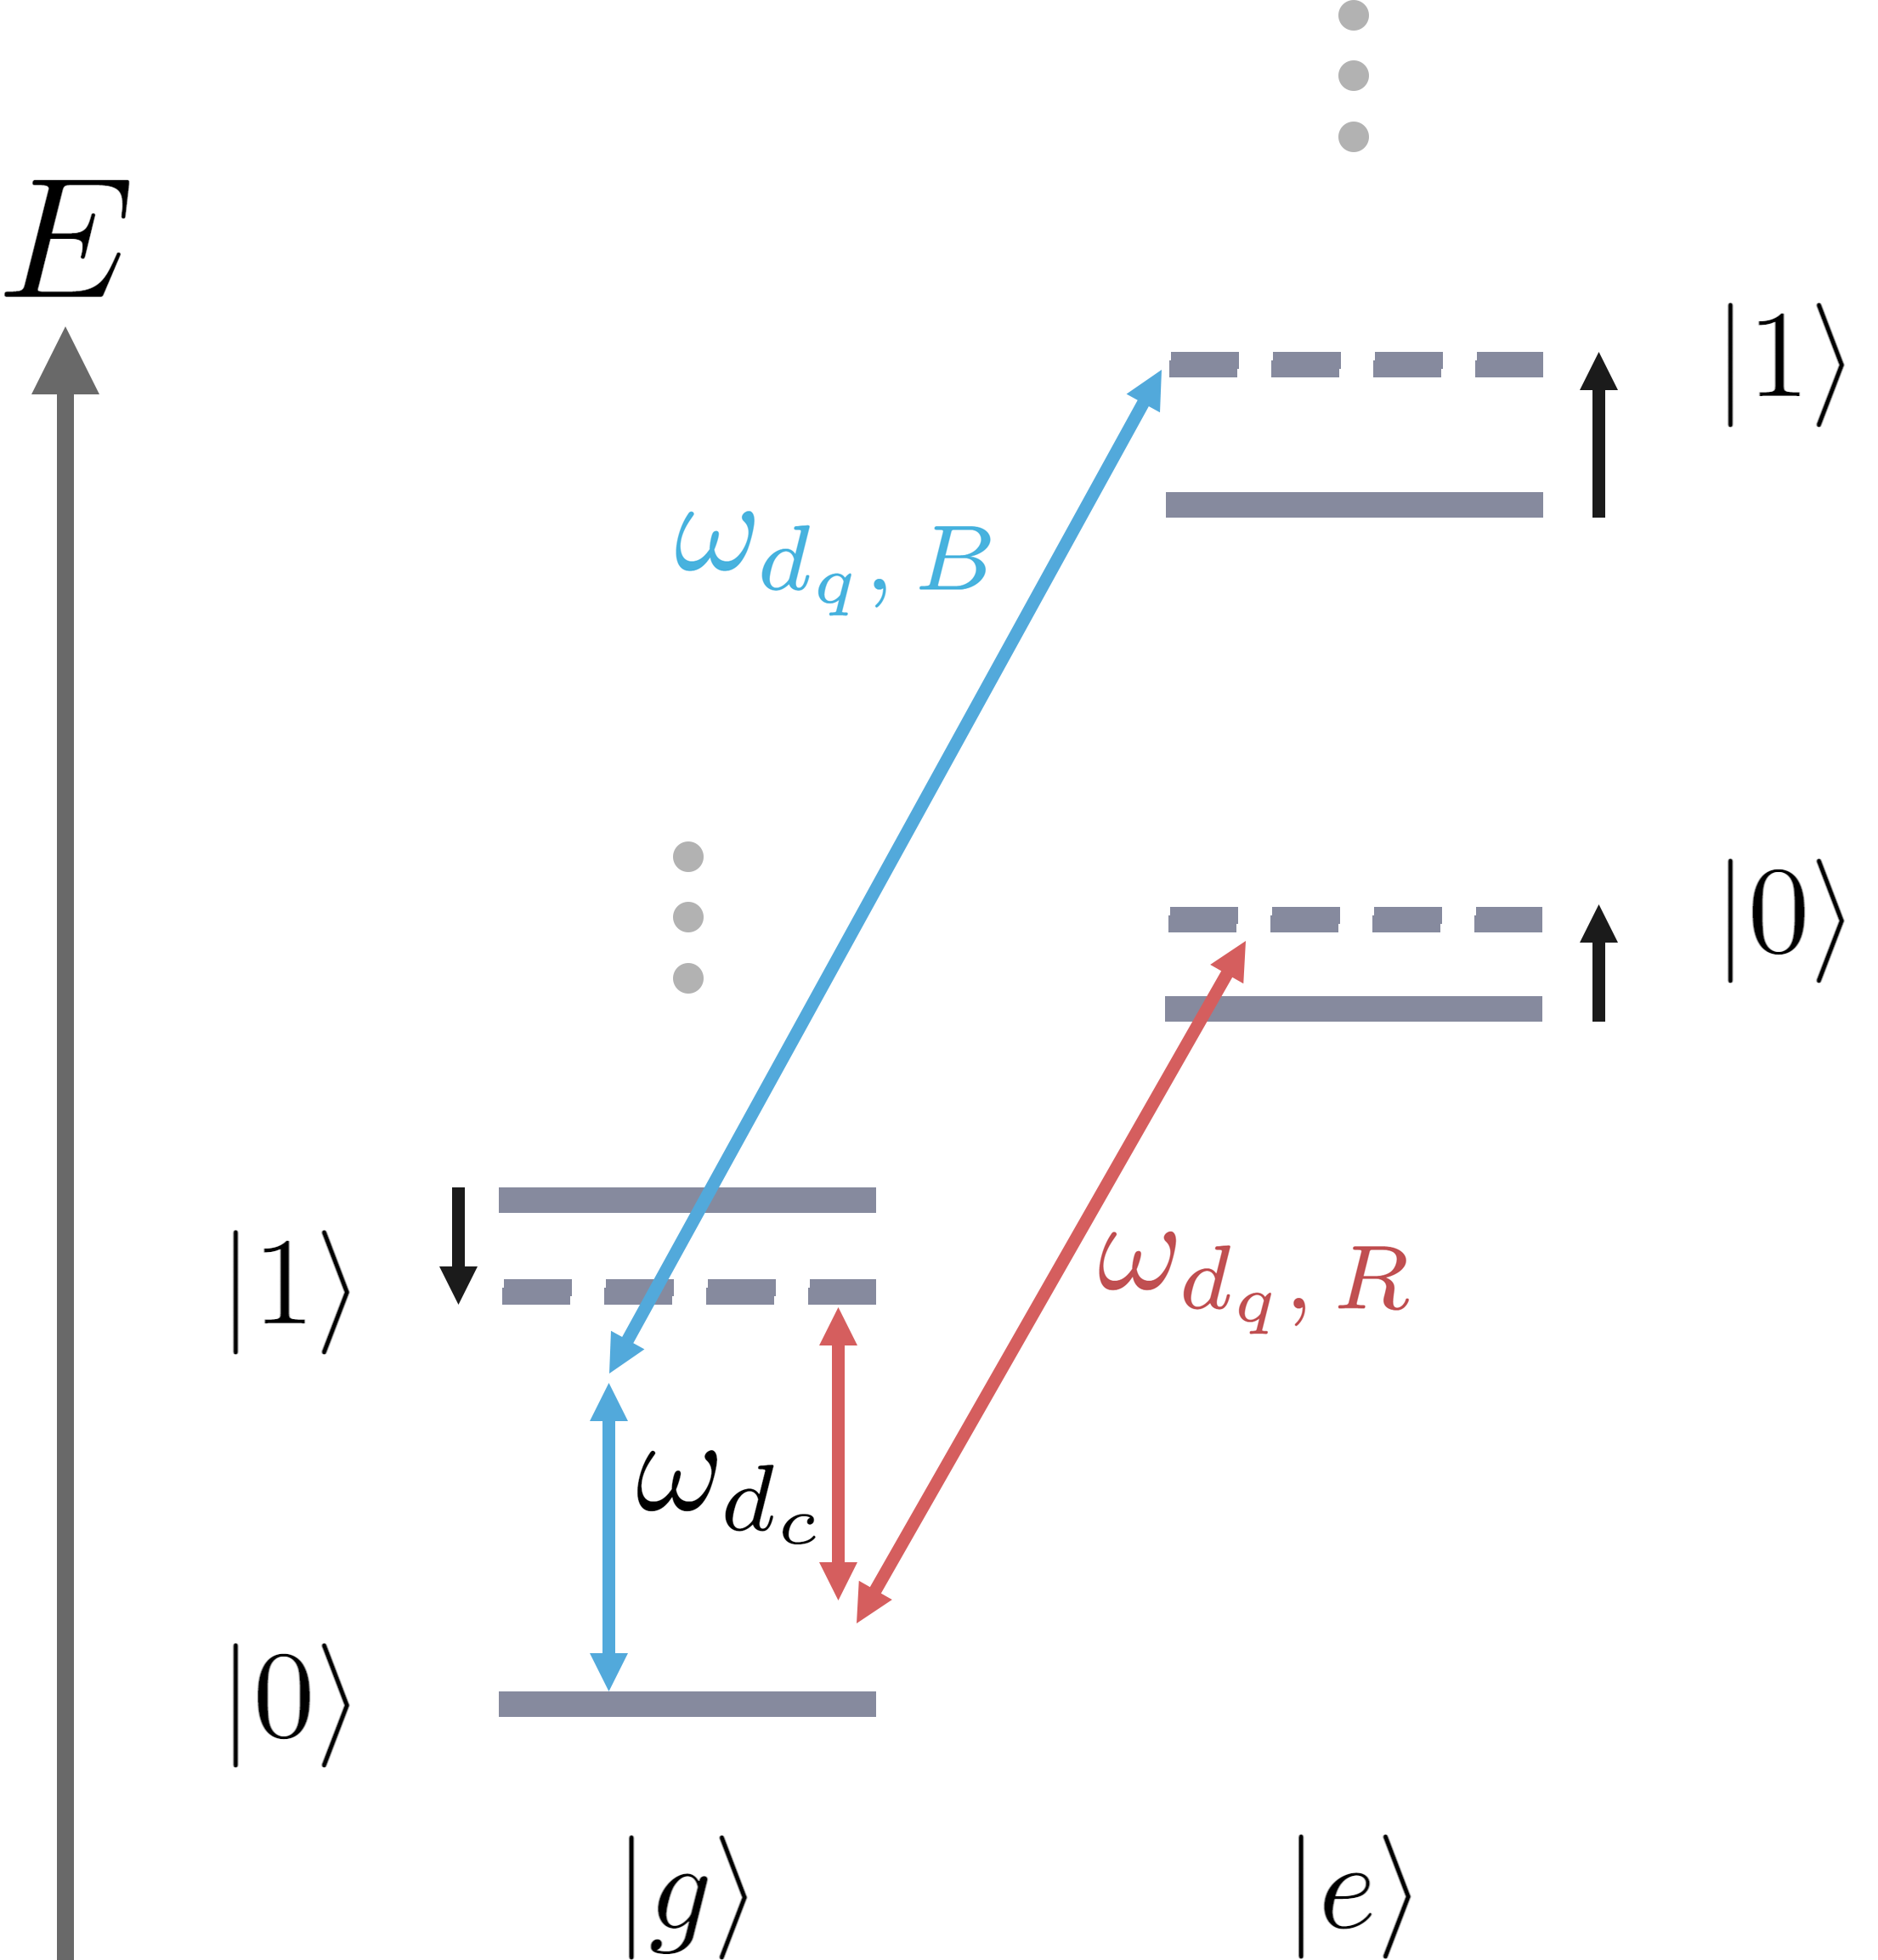</td>
    </tr>
</table>

(Left) Monochromatic driving. (Right) Bi-chromatic driving.

In this notebook, all the states donoted by $\left|e\right>$, $\left|g\right>$ and $\left|n\right>$ refer to dressed states, considering the off-resonant couplings between the qubit and cavity but without external driving field. We call these just 'dressed states' from now on.

Meanwhile, the eigenstates of the system without considering the coupling between the qubit and cavity are called 'bare states'.


### Tricks : Adiabatically increase the qubit-cavity coupling.

The qubit and cavity are always coupled to each other,and therefore when we calculate the expectation values out of the systems, the calculation should be done on the dressed state basis. However, it is inconvenient to define quantum states in dressed state basis of the systems in Qutip. To solve this, we invoke our own approach to adiabatically increase the coupling constant between qubit 

Because the system is by default initiated in an eigenstate of the uncoupled system, 
it is convenient to initiate the system uncoupled and smoothly increase the coupling and driving strength. 
By doing so, the states are adiabatically transferred from the bare to dressed states at rises and vice versa at falls.
This is to reduce undesired oscillatory quantum behaviour of a system that is not in one of its eigenstates. 


It is structured with the following sections:
0. Import packages and modules.
1. Simulation settings. Set all the required parameters and options for simulation.
2. Calculate. Perform the time simulation.
3. Process results. Save the parameters, combine separate batches per quantity and calculate the sideband transition rate.
4. Plot results.
5. Save results. Change temporary folder to saved folder, when you are satisfied with the data.\
Appendix. Scanning. Sweep drive or probe frequency to find the matching frequency that yields a resonant sideband transition. Paralell processing is implemented to save times.

This notebook makes use of open-source packages like QuTiP, and of supplementary cQED modules built in-house. Here follows a very brief description of what these cQED modules contain:
- `calculate`: functions calculating the evolution, required drive frequency and transition rate,
- `envelopes`: functions providing time dependence of Hamiltonian terms for QuTiP's solver,
- `scan`: functions to simulate for a given driving or probe frequency, and other given parameters,
- `process`: functions processing the data, and handling batches and folders,
- `plotsettings`: plot settings that will be used for all generated plots,
- `plots`: functions to plot the obtained data from the simulation,
- `supports`: several global variables and function to reduce typing, and other functions.

# Import packages and modules

In [45]:
# Magic commands
%matplotlib inline
# %matplotlib notebook
# External packages
import os
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from qutip import *
from pylab import *
from ipywidgets import widgets
from IPython.display import display, HTML

# cQED modules
from plotsettings import *
from plots import *
from supports import *
from process import *
from calculate import *
from envelopes import *
from scan import *

home = os.getcwd() + "/"

# Simulation settings


# Set physical parameters
Let's define the parameters used in the simulation. 

Note that all frequency- and energy-related variables are in units of ns and Grad/s, and that we work with natural units of $\hbar=1$.

## Set parameters of qubit, cavity, and their couplings.

We model the qubit in two ways here. One is a transmon qubit (the most popular type of superconducting qubits) and the other is a two-state system. Depdending on how you set $N_q$ (the number of the qubit's energy level considered in the simulations), the code performs a calculation with different qubit model and therefore the meaning of the parameters will be different. Please see below. 

### Dispersively coupled a Transmon and cavity mode.
When the qubit has more than two energy levels ($N_q > 2$), this notebook gives us two ways to deal with the anharmonicity between the levels. We can choose for a Duffing oscillator, where the qubit's bare, the system Hamiltonian is given by

\begin{equation}
    \hat{H}_q = \omega_q' \hat{b}^\dagger \hat{b} - \frac{E_C}{12} \left( \hat{b} + \hat{b}^\dagger \right) ^4
    + g (\hat{b} + \hat{b}^\dagger) (\hat{a} + \hat{a}^\dagger) + \omega_c \hat{a}^\dagger \hat{a} ,
\end{equation}

where $\omega_q' = \sqrt{8E_J E_C}$ and $omega_c$ are the bare qubit and cavity frequency. This form is derived from the transmon regime where $E_J / E_C \gg 1$ and where the anharmonicity is only a small perturbation on the harmonic behaviour. We can also choose for the common Kerr approximation which removes all off-diagonal elements from the fourth-power term, corresponding to the rotating wave approximation (RWA) by removing the fast rotating terms in the interaction picture. The qubit's Hamiltonian then becomes

\begin{equation}
    \hat{H}_q = \omega_q \hat{b}^\dagger \hat{b} - \frac{E_C}{2} \hat{b}^\dagger \hat{b}^\dagger \hat{b} \hat{b}
    + g (\hat{b} + \hat{b}^\dagger) (\hat{a} + \hat{a}^\dagger) + \omega_c \hat{a}^\dagger \hat{a},
\end{equation}

where $\omega_q = \omega_q' - E_C$. The first option can be chosen by setting the boolean variable `anh_appr` to `False`, the second by setting it to `True`.

### Dispersive quantum Rabi model.
When $N_q = 2$, the system Hamiltonian in the simulation becomes the same as the quantum Rabi model given below,

\begin{equation}
    \hat{H}_{q} = \omega_q \hat{\sigma}_z + g\hat{\sigma}_{x}(\hat{a} + \hat{a}^\dagger) + \omega_c \hat{a}^\dagger \hat{a}.
\end{equation}

Note that in this case, ladder operator $\hat{b}$ in the code serves as a Pauli operator $\sigma_{-}$.


## Set the driving parameters and initial states

These parameters are related with driving fields and initial states in the simulation.

The type of sideband transition is set by the variable `sb` and is either `'red'` ($\left|e0\right>$-$\left|g1\right>$) or `'blue'` ($\left|e1\right>$-$\left|g0\right>$). This notebook allows the drive to be either monochromatic ($N_t = 1$) or bichromatic ($N_t = 2$), but the transitions always include two photons. That is because single-photon transitions are prohibited for a transmon and for a TLS transversively coupled to the cavity.

In the case of bichromatic driving, the two photons involved in a transition are of different frequencies. The cavity-friendly tone is set by `omega_c-d_omega` and the bare cavity frequency, which should have a value small enough to keep the transition rate sufficiently high, but large enough so that there is no independent emission or absorption by the cavity. The qubit-friendly drive tone is then the one that induces either the red or blue sideband transitions, normally around `omega_q+d_omega` Although the words cavity/qubit friendly only make sense when `d_omega` is small enough compared with  but we do not restrict `d_omega` with small values 

We model the driving Hamiltonian in three ways, `Full`, `RWA`, and `CR`.

In addition to the above, we have parameter `psi0` that determines initial state in the simulation. Depends on the type of sideband transitions. 


## Set time parameters
These parameters determine the length of the simulation in time and at an what time the drive and coupling are turned on and of.

`H_args`               : Collect all the time related variables.

Time cylcle            : \
    `t0` : start of simulation. \
    `t1` : start of drive and coupling\
    `t2` : end of drive of drive and coupling\
    `t3` : end of simulation
    
Gaussian rise and fall :\
    `tg`     :  length of the ramp up and down duration of the $\Omega_d$ and $g$.\
    `gauss`  :  whether or not to rise and fall with gaussian, if False, coupling and driving fields are suddently switched on.\
    `smooth` :  whether to start gaussian at 0 or with small jump\
    `Q`      :  number of std's in gaussian rise and fall.

## The others

`e_ops` : Return the expectation value of these quantities.\
`c_ops` : Collapse operators if you want to introduce dissipation.


## Result : Total Hamiltonian
Because of the periodic drive and the rise and fall of the coupling, the total Hamiltonian is time-dependent. For the full driving Hamiltonian, it is given by

\begin{align}
    \hat{H} & = \hat{H}_q + \hat{H}_c + \hat{H}_g (t) + \hat{H}_d (t)\\
            & = \hat{H}_q + \omega_c \hat{a}^\dagger \hat{a} + g(t) (\hat{b} + \hat{b}^\dagger) (\hat{a} + \hat{a}^\dagger)
            + \Omega_d(t) \cos (\omega_d t) (\hat{b} + \hat{b}^\dagger)
\end{align}

where $\hat{H}_q$ is given by the choice of anharmonocity above. In the case of bichromatic driving, $\hat{H}_d$ is given by

\begin{equation}
    \hat{H}_d = \Omega_{dq}(t) \cos (\omega_{dq} t) (\hat{b} + \hat{b}^\dagger) + \Omega_{dc}(t) \cos (\omega_{dc} t) (\hat{b} + \hat{b}^\dagger),
\end{equation}

where the subscript $dq$ represents the qubit-friendly drive tone, and $dc$ the cavity-friendly drive tone. The time dependence is passed on to the solver by functions defined in the `envelopes` module. `H_args` is a dictionary containing variables required for proper handling of the time dependence of $\hat{H}$.

In [46]:
# System 
Nq = 2           # number of levels in qubit
Nc = 10          # number of levels in cavity
omega_q = 6.5 *2*pi  # g-e qubit transition frequency
omega_c = 4.0 *2*pi  # bare cavity frequency
Ec = 0.2 *2*pi       # anharmonicity (charging energy)
g  = 0.2 *2*pi       # coupling between qubit and cavity
kq = 50e-6*2*pi    # qubit linewidth
kc = 0e-6 *2*pi       # cavity linewidth


# Anharmonicity approximation
anh_appr = True  # remove off-diagonal elements in anharmomic term of transmon qubit?

# Driving Hamiltonian model
drive_model = 'Full'  # Full, RWA, or CR. 

# Sideband transitions
sb = 'red'  # type of sideband transitions
Nt = 1      # number of drive tones

# Single-tone
Omega_d = 0.3*2*2*pi   #  Sideband dive amplitude
omega_d = 1.2984*2*pi  # monochromatic drive frequency

# Double-tone
Omegafac   = 1                           # factor with which to scale the drive tone amplitudes
Omega_dq   = Omegafac * 0.025 *2 *2*pi  # amplitude of qubit-friendly drive tone
Omega_dc   = Omegafac * 0.317 *2 *2*pi  # amplitude of cavity-friendly drive tone
d_omega    = 0.5 *2*pi                     # detuning of wdc from wc
omega_dq     = 3.41095*2*pi             # frequency of qubit-friendly drive tone
omega_dc     = omega_c - d_omega       # frequency of cavity-friendly drive tone

# These variables determine the simulation time window.
# t0 ~ t1 : No coupling and driving for this duration.
# t1 ~ t2 : The coupling and driving fields ramp up (rise) - constant - ramp down (fall). 
# t2 ~ t3 : No coupling and driving for this duration.
t0 = 0         # start of simulation. 
t1 = t0 + 0    # start of drive and coupling
t2 = t1 + 3020  # end of drive of drive and coupling
t3 = t2 + 0    # end of simulation

# These variables determine the ramp up and down duration.
# Gaussian rise and fall
tg = 10           # length of the ramp up and down duration.
gauss = True     # whether or not to rise and fall with gaussian, if False, coupling and driving fields are suddently switched on.
smooth = False   # whether to start gaussian at 0 or with small jump
Q = 3            # number of std's in gaussian rise and fall

# Set the initial state based on the type of sideband transition
if sb == 'red':
    psi0 = tensor(basis(Nq, 1), basis(Nc, 0))  # Red: qubit excited, cavity in ground state
elif sb == 'blue':
    psi0 = tensor(basis(Nq, 0), basis(Nc, 0))  # Blue: both qubit and cavity in ground state

# Store time related arguments for solver. Gives numerics to the time dependent parts of the Hamiltonian.
if Nt == 1:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'Q'  : Q, 'gauss' : gauss,
              'smooth' : smooth, 'Nt' : Nt, 'omega_d' : omega_d}
elif Nt == 2:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'Q'  : Q, 'gauss' : gauss,
              'smooth' : smooth, 'Nt' : Nt, 'omega_dq' : omega_dq, 'omega_dc' : omega_dc}

# Bulid a Hamiltonian and set initial conditions

In this part, we will determine the Hamiltonian and the initial quantum states based on the parameters we set above .

In [47]:
b, a, nq, nc = ops(Nq, Nc)  # Operators

# Individual Hamiltonian terms
if anh_appr or Nq == 2:
    Hi = omega_q*nq + omega_c*nc - Ec/2*b.dag()*b.dag()*b*b 
else:
    Hi = (omega_q+Ec)*nq + omega_c*nc - Ec/12*(b + b.dag())**4

# Combine terms to complete Hamiltonian and include time dependence
Hc = g*(a + a.dag())*(b + b.dag())  # coupling

if drive_model == 'Full':             # No RWA in this case.
    if Nt == 1:
        Hd = Omega_d*(b + b.dag())    # single-tone drive
    elif Nt == 2:
        Hdq = Omega_dq*(b + b.dag())  # double-tone qubit-friendly drive
        Hdc = Omega_dc*(b + b.dag())  # double-tone cavity-friendly drive

    if Nt == 1:
        H = [Hi, [Hc, drive_nonosc], [Hd, drive]]  # monochromatic drive
    elif Nt == 2:
        H = [Hi, [Hc, drive_nonosc], [Hdq, driveq], [Hdc, drivec]]  # bichromatic drive

elif drive_model == 'RWA':              # Only co-rotating terms in the driving Hamiltonian.
    if Nt == 1:
        Hdp = Omega_d/2*b
        Hdm = Omega_d/2*b.dag()
    elif Nt == 2:
        Hdp_q = Omega_dq*(b + b.dag())  # double-tone qubit-friendly drive
        Hdp_c = Omega_dc*(b + b.dag())  # double-tone qubit-friendly drive
        Hdm_q = Omega_dq/2*b.dag()
        Hdm_c = Omega_dc/2*b.dag()

    if Nt == 1:
        H = [Hi, [Hc, drive_nonosc], [Hdp, drive_no_CR_p], [Hdm, drive_no_CR_m]]
    elif Nt == 2:
        H = [Hi, [Hc, drive_nonosc], [Hdp_q, driveq_no_CR_p], [Hdm_q, driveq_no_CR_m],[Hdp_c, drivec_no_CR_p], [Hdm_c, drivec_no_CR_m]]

elif drive_model == 'CR':               # Only counter-rotating terms in the driving Hamiltonian.
    if Nt == 1:
        Hdp = Omega_d/2*b
        Hdm = Omega_d/2*b.dag()
    elif Nt == 2:
        Hdp_q = Omega_dq*(b + b.dag())  # double-tone qubit-friendly drive
        Hdp_c = Omega_dc*(b + b.dag())  # double-tone qubit-friendly drive
        Hdm_q = Omega_dq/2*b.dag()
        Hdm_c = Omega_dc/2*b.dag()

    if Nt == 1:
        H = [Hi, [Hc, drive_nonosc], [Hdp, drive_no_CR_m], [Hdm, drive_no_CR_p]]
    elif Nt == 2:
        H = [Hi, [Hc, drive_nonosc], [Hdp_q, driveq_no_CR_m], [Hdm_q, driveq_no_CR_p],[Hdp_c, drivec_no_CR_m], [Hdm_c, drivec_no_CR_p]]

# Set the initial state based on the type of sideband transition
if sb == 'red':
    psi0 = tensor(basis(Nq, 1), basis(Nc, 0))  # Red: qubit excited, cavity in ground state
elif sb == 'blue':
    psi0 = tensor(basis(Nq, 0), basis(Nc, 0))  # Blue: both qubit and cavity in ground state

# Estimate for the required drive frequency

The below is estimating the matching frequency for given parameters based on perturbation theory.\
Please check your `omega_d` or `omega_dq`/`omega_dc` is reasonable.\
The calculation is based on the perturbation theory, and therefore not accurate for strong driving fields.

In [30]:
#Estimate the required drive frequency
_ = drivefreq(Nq, omega_q, omega_c, Hi+Hc, sb, Nt, Omega_d=Omega_d, Omega_dq=Omega_dq, Omega_dc=Omega_dc, d_omega=d_omega, Ec=Ec,
              resolution=0.0001*2*pi, verbose=True, anharm='nonlin')

Estimated drive frequency omega_d = 1.2984 GHz


If you want to estimate the expected matching frequency when assuming the rotating wave approximation in the driving terms, please use the below function.

In [59]:
#Estimate the required drive frequency with the RWA in the driving terms.
_ = drivefreq_RWA(Nq, omega_q, omega_c, Hi+Hc, sb, Nt, Omega_d=Omega_d, Omega_dq=Omega_dq, Omega_dc=Omega_dc, d_omega=d_omega, Ec=Ec,
              resolution=0.0001*2*pi, verbose=True, anharm='nonlin')

Estimated drive frequency omega_d = 5.2775 GHz


# Calculate

`calcuate` : 
Simulation starts by operating this function. It calculates the dynamics of the systems defined by the parameters we set above. Before starting, we should complete the setting for the `calcuate` function.  


# Set calculation method.


## Convergent method

Here, what we call 'convergent method' amounts to the simulation method present in the paper (xxx.xxx).
This method is switched on by setting the `convergent` variable to `True`.
When `convergent` is `False`, then `calcuate` just solve the master equation in a normal way. 


## Time steps and batches
We can choose the number of equidistant points `Np` in time for which the solver stores the output. In between these points, QuTiP's `Options` class provides the choice of the maximum number of points that can be used for integration. Large `Np` will provide detailed plots of the evolution but will, needlessly to say, consume more memory.

Since it is convenient to save the entire evolution for later use, the states $\psi(t)$ of the system are kept. But these objects will quickly consume large amounts of RAM. So the evolution is automatically divided into batches. The system's evolution within one batch (corresponding to a specific period of time) is saved to a `pickle` file in the '/temp/' folder at `home` directory and deleted from RAM. Later on, the expectation values through the entire evolutions are retrieved from these files again.

There will probably be an optimum value for the number of points per batch that minimizes the computation time of writing data to files and keeping many variables in the RAM, but I have never calculated what this ratio would be. 10 ns per batch, with time steps of 10 ps seems to work well.

The convergent method has its own line for the number of data points. This is because this method is much more computationally intensive, since the evolution during the fall of the drive and coupling must be calculated again for each new data point. So make sure that, for reasonable computation times, you do not choose `Np` too large.

In [48]:
# Convergent method
convergent = False   # use convergent method
refinement = 100     # only meaningful when convergent is true. Just put any number if you do not use convergent method.

# Set the expectation and collapse operators.
e_ops = [nq, nc]  # expectation operators
c_ops = []        # collapse operators
# c_ops = [sqrt(kq)*b]  # collapse operator(s)


# Integration
method = 'bdf'  # mesolve's integration method, either 'bdf' or 'adams'

# Set the options for the Lindblad ME solver
options = Options()
options.store_states=True

if method == 'bdf':
    options.method = 'bdf'
    options.rtol = 1e-11
    options.atol = 1e-11
else:  # adams
    options.nsteps = 1000
    options.rtol = 1e-11
    options.atol = 1e-11
    options.max_step = 0

# Set the time steps for which to store the output of the solver
if not convergent:
    Np = 10 *int(t3)  # number of data points in time
    print("timestep =", 1e3*np.round(t3/Np, 5), "ps")
elif convergent:
    Np = 0.1*int(t3-2*tg)    # number of data points in time
    print("timestep =", 1e3*np.round((t3-2*tg)/Np, 5), "ps")
Np_per_batch = 1000          # number of time points per batch
Nbatch = int(Np/Np_per_batch)  # number of batch
print("The points per a batch =",Np_per_batch)
print("The number of the batch =",Nbatch)

timestep = 100.0 ps
The points per a batch = 1000
The number of the batch = 30


## Start calculation.

Now we have set all the parameters to numerically calculate the system's evolution over time!  

Let's operate `calcuate` function.  
It saves the evolution for each batch and returns the name of the folder with all the data. This folder name can be used as a reference for the simulation, but also the ID it is given, which is a date and time stamp to second precision.

Important note: all folders within the '/temp/' folder are removed when running the `calcuate` function and its `parallel` argument is set to `False`.

`parallel` function is not available yet.

In [49]:
progfolder = calculate(H, psi0, e_ops, c_ops, H_args, convergent, refinement, options, Nc, Np, Np_per_batch, home,
                       parallel=False, verbose=True, method='me')

Progress: |██████████████████████████████████████████████████| 100.0%
Evolution completed in 6 min


# Process results
Now that the calculations are finished we have to process the data and take care of the results.

## Save parameters
First, we are going to save all the parameters to a file (.txt and .pkl), for easy documentation and readout.

In [50]:
# Save the parameters that are used.

if Nt == 1:
    saveparams(Nq, Nc, Nt, omega_q, omega_c, Ec, g, sb, t0, t1, t2, t3, tg, anh_appr, gauss, smooth, Q, convergent,
               Np, H, psi0, e_ops, options, progfolder, frmt=['pkl', 'txt'], Omega_d=Omega_d, omega_d=omega_d)
elif Nt == 2:
    saveparams(Nq, Nc, Nt, omega_q, omega_c, Ec, g, sb, t0, t1, t2, t3, tg, anh_appr, gauss, smooth,
               Q, convergent, Np, H, psi0, e_ops, options, progfolder, frmt=['pkl', 'txt'],
               Omega_dq=Omega_dq, Omega_dc=Omega_dc, omega_dq=omega_dq, omega_dc=omega_dc, d_omega=d_omega)

## Load parameters
Then we load all parameters from the `pickle` file into RAM. It may seem odd and unnecessary to this, since they are all defined above. The reason is that the next cell provides the functionality to load from any data folder available, and that specific simulation may have other settings. `srcfolder` should be the path that leads to this folder.
I advise, though, to make use of the `analyze` notebook for analysis of previously performed simulations.

In [51]:
# Load parameters
srcfolder = progfolder  # path to the folder to get the data from

new_folder_name = copy(srcfolder)
ID = getID(srcfolder)  # unique simulation ID

# Get the parameters that are used
Nq, Nc, Nt, omega_q, omega_c, Ec, g, sb, t0, t1, t2, t3, tg, anh_appr, gauss, smooth, Q, convergent, Np, H, psi0, e_ops, options, Omega_d, omega_d, Omega_dq, Omega_dc, d_omega, omega_dq, omega_dc = getparams(srcfolder)
if Nt == 1:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'Q' : Q,
              'gauss' : gauss, 'smooth' : smooth, 'Nt' : Nt, 'omega_d' : omega_d}
elif Nt == 2:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'Q' : Q, 'gauss' : gauss,
              'smooth' : smooth,  'Nt' : Nt, 'omega_dq' : omega_dq, 'omega_dc' : omega_dc}

## Extract calculated quantities
At this point, all calculated quantities such as expectation values and occupation probabilities are still divided over multiple batches, but we want these quantities as individual objects for easy handling. Therefore we extract these quantities from the individual batches and save them to dedicated `pickle` files and load them into RAM. `quants` determines for which quantities this is done.
Note that loading all the quantum states with the argument `states` will probably consume all your memory and crash the system.

When you operate `combine_batches_update`, it deletes the previously combined files with the same `start` and `stop` variables.  

In [52]:
# Combine all batches per quantity 
quants = ['times', 'states','expect', 'e0', 'g1', 'e1', 'g0','coupling']  # quantities to extract from data folder

start_comb = datetime.now()                                        # Time when starting 'combine_batches function.'
combine_batches_update(srcfolder, start = None, stop = None, quants=quants, return_data=False)
print("Batches combined    in {} s".format((datetime.now() - start_comb).total_seconds())) 

Batches combined    in 8.831864 s


## Load the combined data 
`quants`, `srcfolder`,`start`, and `stop` variables must be the same in those used in `combine_batches_update`.

In [53]:
times, states, expect, e0, g1, e1, g0, coupling = load_data_update(quants, srcfolder, start = None, stop = None)  # load to RAM

## Calculate sideband transition rate
With the obtained data we can measure the sideband transition rate $\Omega_{sb}$ by looking at the extrema of the combined prbabilities:
- $P({\left|e0\right>}) - P({\left|g1\right>})$ for the red sideband transitions, and
- $P({\left|e1\right>}) - P({\left|g0\right>})$ for the blue sideband transitions.

But due to the driving, there will be micromotion present in the signal, resulting in many extrema. This micromotion should be filtered out first before determining the transition rate. This is done by the `remove_micromotion` function from the `calculate` module, which accepts 3 choices of method:
- `'savgol'`: Savitsky-Golay filter,
- `'bisect'`: data point in the middle of the bisectional line connecting two neighbouring extrema,
- `'lowpass'`: low-pass filter.

The transition rate is subsequently calculated by `sideband_freq`. If the systen has not undergone one full oscillation, a warning is raised and the transition rate will be set to zero.
Note that the rise and fall influence the local evolution. Therefore extrema that fall within the rise and fall are not included in determining the transition rate.

In [54]:
# Determine the sideband transition rate
smoothen_method = 'lowpass'  # method to remove micromotion, either 'savgol', 'bisect', or 'lowpass'

if not convergent:
    if 'e0' in quants:
        e0_macro, e0_macro_times = remove_micromotion(e0, times, method=smoothen_method)
    if 'g0' in quants:
        g0_macro, g0_macro_times = remove_micromotion(g0, times, method=smoothen_method)
    if 'e1' in quants:
        e1_macro, e1_macro_times = remove_micromotion(e1, times, method=smoothen_method)
    if 'g1' in quants:
        g1_macro, g1_macro_times = remove_micromotion(g1, times, method=smoothen_method)
    if ('e1' in quants and 'g0' in quants):
        e1g0_macro, e1g0_macro_times = remove_micromotion(e1-g0, times, method=smoothen_method)
    if ('e0' in quants and 'g1' in quants):
        e0g1_macro, e0g1_macro_times = remove_micromotion(e0-g1, times, method=smoothen_method)

    if sb == 'red':
        Omega_sb = sideband_freq(e0g1_macro, e0g1_macro_times)
    elif sb == 'blue':
        Omega_sb = sideband_freq(e1g0_macro, e1g0_macro_times)

elif convergent:
    if sb == 'red':
        Omega_sb = sideband_freq(e0-g1, times)
    elif sb == 'blue':
        Omega_sb = sideband_freq(e1-g0, times)

print("sideband transition freq   wsb = {} GHz".format(Omega_sb/2/pi))
if Omega_sb > 0:
    print("sideband transition period Tsb = {} ns".format(2*pi/Omega_sb))

sideband transition freq   wsb = 0.006644411457605808 GHz
sideband transition period Tsb = 150.50241942125777 ns


#  Plot evolution
All these calculations and simulations are very nice of course, but let's now see what actually happens. We will plot the evolution in two different ways here:
- the expectation values of both the qubit and the cavity,
- the combined probability $P({\left|e0\right>}) - P({\left|g1\right>})$ in the case of red sideband transitions and $P({\left|e1\right>}) - P({\left|g0\right>})$ in the case of blue.

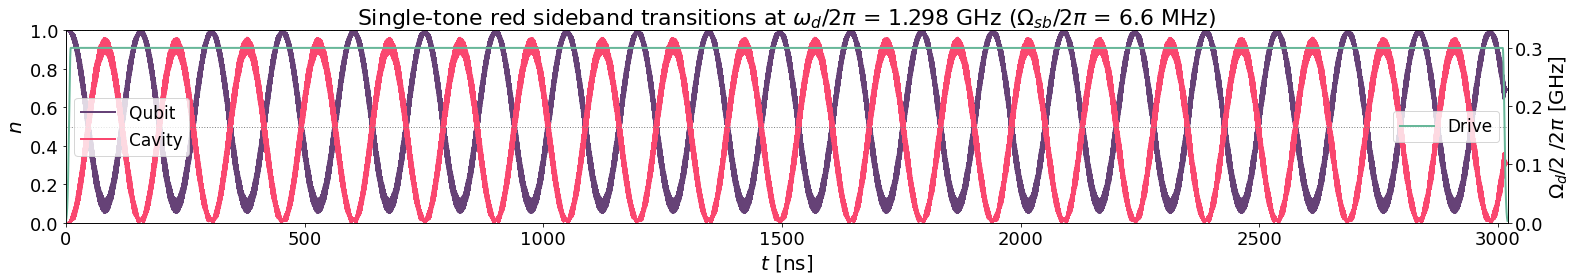

In [56]:
# Plot expectation values
xlim = None       # range of horizontal axis
ylim = None       # range of vertical axis
figsize = [22,4]  # figure size
# wsb = 1 # dummy number

if sb == 'red':
    if Nt == 1:
        figqc, axqc = sb_expect(times, expect, sb, Nt, H_args, convergent, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          Omega_sb=Omega_sb, Omega_d=Omega_d, omega_d=omega_d)
    elif Nt == 2:
        figqc, axqc = sb_expect(times, expect, sb, Nt, H_args, convergent, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          Omega_sb=Omega_sb, Omega_dq=Omega_dq, Omega_dc=Omega_dc)
elif sb == 'blue':
    if Nt == 1:
        figqc, axqc = sb_expect(times, expect, sb, Nt, H_args, convergent, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          Omega_sb=Omega_sb, Omega_d=Omega_d, omega_d=omega_d)
    elif Nt == 2:
        figqc, axqc = sb_expect(times, expect, sb, Nt, H_args, convergent, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          Omega_sb=Omega_sb, Omega_dq=Omega_dq, Omega_dc=Omega_dc)

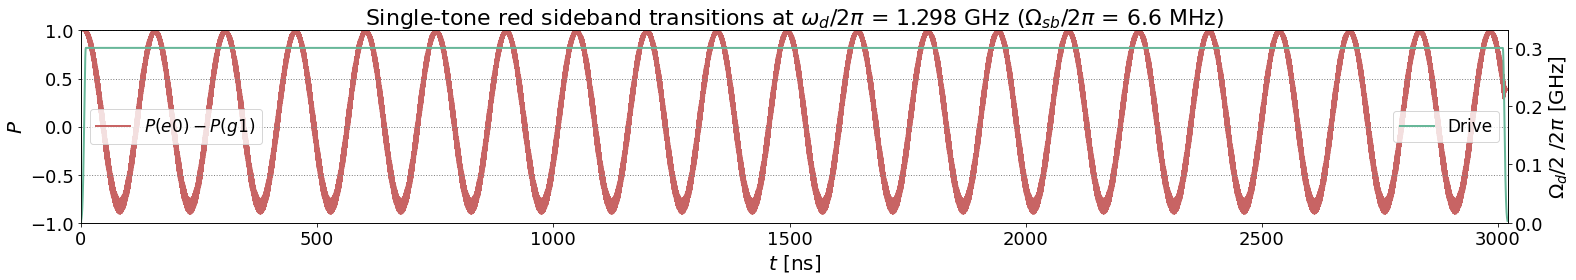

In [57]:
# Plot combined probabilities
xlim = None       # range of horizontal axis
ylim = None       # range of vertical axis
figsize = [22,4]  # figure size
# wsb = 1 # dummy number

if sb == 'red':
    if Nt == 1:
        fig, axp = sb_combined_probs(times, sb, Nt, H_args, convergent, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                                e0=e0, g1=g1, omega_d=omega_d, Omega_sb=Omega_sb, Omega_d=Omega_d)
    elif Nt == 2:
        fig, axp = sb_combined_probs(times, sb, Nt, H_args, convergent, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                                e0=e0, g1=g1, Omega_sb=Omega_sb, Omega_dq=Omega_dq, Omega_dc=Omega_dc)
elif sb == 'blue':
    if Nt == 1:
        fig, axp = sb_combined_probs(times, sb, Nt, H_args, convergent, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                                e1=e1, g0=g0, omega_d=omega_d, Omega_sb=Omega_sb, Omega_d=Omega_d)
    elif Nt == 2:
        fig, axp = sb_combined_probs(times, sb, Nt, H_args, convergent, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                                e1=e1, g0=g0, Omega_sb=Omega_sb, Omega_dq=Omega_dq, Omega_dc=Omega_dc)

# . Save data and plots
If we are satisfied with the simulation and we want to save it for later, click the button below which sais "Save data". This saves all the information, including the entire evolution, quantity files and the two above figures, to a new folder in the '/data/' folder, and removes the old temporary folder. The new folder's name contains the simulation ID and some basis parameter values. Furthermore, the sideband transition rate is added to the "parameter.txt" file.

In [44]:
# Save all data and plots with a single click on the button!
data_saved = False
data_button = widgets.Button(description='Save data')
data_out = widgets.Output()
def data_clicked(b):
    data_button.description = 'Data saved!'
    with data_out:
        global srcfolder 
        
        parfile = open(srcfolder + "/parameters.txt", "a+")
        parfile.write("sideband transition frequency   Omega_sb    : {} = {} GHz\n".format(Omega_sb, Omega_sb/2/pi))
        parfile.write("sideband transition coupling    g_sb         : {} = {} GHz".format(Omega_sb/2, Omega_sb/2/2/pi))
        parfile.close()
        
        if convergent==True :
            methodology = 'true'
        else :
            methodology = 'false'
    
        if Nt == 1:
            new_folder_name = "/home/jovyan/jupyterhub-shared/B_Ann/2P-Sideband/data_{}_convergent_{}_{}_{}_Nq{}_Nt{}_Omega_d_{}_wd{}_omega_q{}_omega_c{}_Omega_sb{}".format(
                              ID, methodology, drive_model, sb, Nq, Nt, round(Omega_d/2/pi, 2), round(omega_d/2/pi, 3), round(omega_q/2/pi, 2),
                              round(omega_c/2/pi, 2), round(Omega_sb/2/pi, 4))
            figqc.savefig(srcfolder + "/" + "figqc_{}.png".format(ID, bbox_inches='tight'))
            fig.savefig(srcfolder + "/" + "fig_{}.png".format(ID, bbox_inches='tight'))
        elif Nt == 2:
            new_folder_name = "/home/jovyan/jupyterhub-shared/B_Ann/2P-Sideband/data_{}_convergent_{}_{}_{}_Nq{}_Nt{}_Omega_dq{}_omega_dq{}_Omega_dc{}_omega_dc{}_omega_q{}_omega_c{}_Omega_sb{}".format(
                              ID, methodology, drive_model, sb, Nq, Nt, round(Omega_dq/2/pi, 2), round(omega_dq/2/pi, 3), round(Omega_dc/2/pi, 2),
                              round(omega_dc/2/pi, 3), round(omega_q/2/pi, 2),
                              round(omega_c/2/pi, 2), round(Omega_sb/2/pi, 4))
            figqc.savefig(srcfolder + "/" + "figqc_{}.png".format(ID, bbox_inches='tight'))
            fig.savefig(srcfolder + "/" + "fig_{}.png".format(ID, bbox_inches='tight'))
        shutil.move(srcfolder, new_folder_name)
        print("Folder renamed to", new_folder_name)
        srcfolder = copy(new_folder_name)
data_button.on_click(data_clicked)
widgets.VBox([data_button, data_out])

# Appendix. Scanning

$\textbf{Before operate this part, please complete 1-1, 1-2, and 2-1 in advance.}$

For all the above, the frequency has to be given. But in order to find the correct driving frequency $\omega_d$ that induces sideband transitions we could like to sweep the driving frequency around the estimated required frequency. For every $\omega_d$ a simulation is performed with the parameters set in section 1. Parameters. The frequency range is given by `omega_ds`. To speed up the calculation time, simulations can be run in parallel. `Npool` is the number of parallel simulations, which is of course limited by the number of available cores.

The function `sbsample` outputs two plots for every simulation with a print of the corresponding driving frequency, global maximum value of the combined probability and the global minimum. Note that before beginning the calculations, all existing folders and figures in the '/temp/' folder are deleted.

`scan_result` has four component. The first two are figure object, which amount to the plotted figure-pairs listed below.
The third component is the driving frequency which is scanned by this code. The fourth component is state transition fidelity for given simulation time window. If you want to see fidelity near unity, then the time window should be wide enough to have at least a half oscillation.

In [25]:
_ = drivefreq(Nq, omega_q, omega_c, Hi+Hc, sb, Nt, Omega_d=Omega_d, Omega_dq=Omega_dq, Omega_dc=Omega_dc, d_omega=d_omega, Ec=Ec,
              resolution=0.0001*2*pi, verbose=True, method='SBS', anharm='nonlin')

Estimated drive frequency omega_d = 5.3543 GHz


In [26]:
omega_ds = np.linspace(5.35*2*pi, 5.36*2*pi,11)  # (qubit-friendly) drive frequency range to scan
Npool = 11  # number of parallel simulations

for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all existing progfiles
for figure in glob(home + "temp/fig*"):
    os.remove(figure)  # delete all existing figures
omega_ds = zip(range(len(omega_ds)), omega_ds)
pool = mp.Pool(Npool)
if Nt == 1:
    scan_result = pool.starmap(sbsample, [(Nq, omega_q, omega_c, Ec, g, omega_dsi, sb, Nt, H, H_args, convergent, refinement, psi0, c_ops, Np_per_batch, options, home, True,
                             Omega_d) for omega_dsi in omega_ds])
elif Nt == 2:
    scan_result = pool.starmap(sbsample, [(Nq, omega_q, omega_c, Ec, g, omega_dsi, sb, Nt, H, H_args, convergent, refinement, psi0, c_ops, Np_per_batch, options, home, True, 
                             Omega_dq, Omega_dc, d_omega) for omega_dsi in omega_ds])
pool.close()
for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all progfiles
print("Done.")

Process ForkPoolWorker-2:
Process ForkPoolWorker-9:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-10:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-11:


KeyboardInterrupt: 

Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):


## Plot the frequency scanning results.

You might want to visulize the sideband transition fidelities with respect to the scanned frequencies. The below is what you want. 

In [ ]:
from lmfit import Model 
def lorentzian(x, x0, amp,gamma,offset):
    return amp*(0.5*gamma/((x-x0)**2+0.25*gamma**2)/np.pi)+offset

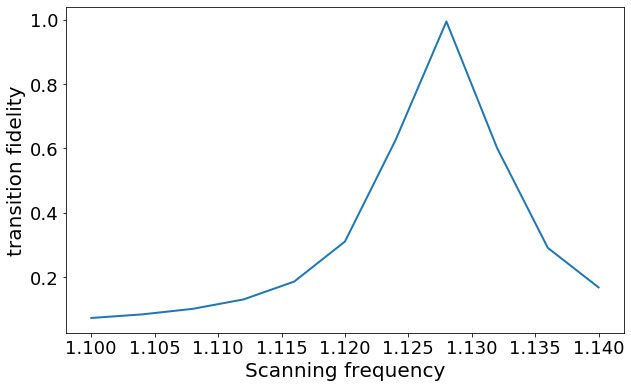

In [11]:
plt.figure()
plt.plot(np.asarray(scan_result)[:,2],np.asarray(scan_result)[:,3])
plt.xlabel('Scanning frequency')
plt.ylabel('transition fidelity')
plt.show()